# Göğüs Röntgen Görüntüleri (Zatürre)
 

Bu projede, zatürre teşhisi için göğüs röntgeni görüntülerinin nasıl kullanıldığı ve veri setinin yapısı hakkında detaylı bilgi verilmiş. Özetlemek gerekirse:

+ Görüntü Kategorileri: Veri seti, "Pnömoni" ve "Normal" olmak üzere iki kategoriye ayrılmıştır. Bu kategoriler, zatürre teşhisi konulan hastaların ve sağlıklı bireylerin göğüs röntgeni görüntülerini içerir.

+ Veri Seti Yapısı: Toplamda 5.863 adet JPEG formatında göğüs röntgeni görüntüsü bulunmaktadır. Bu görüntüler, "eğitim", "test" ve "doğrulama" olmak üzere üç ana klasöre bölünmüştür.

+ Görüntülerin Kaynağı: Görüntüler, Guangzhou Kadın ve Çocuk Tıp Merkezi'ndeki bir ila beş yaş aralığındaki pediatrik hastaların retrospektif kohortlarından alınmıştır.

+ Kalite Kontrol ve Tanı Doğrulama: Analiz için kullanılacak tüm göğüs radyografileri kalite kontrolünden geçirilmiştir. İki uzman hekim, görüntüleri derecelendirmiş, ayrıca derecelendirme hatalarını önlemek için bir üçüncü uzman kontrolü yapılmıştır.

+ Anormal Görüntü Özellikleri:

+ Normal Görüntü: Sol paneldeki röntgen örneği, berrak akciğerleri göstermektedir.
+ Bakteriyel Pnömoni: Orta panelde, sağ üst lobda fokal lober konsolidasyon (beyaz oklarla gösterilen alanlar) bulunmaktadır.
+ Viral Pnömoni: Sağ panelde, her iki akciğerde daha yaygın bir "interstisyel" desenle gösterilmektedir.

Bu projede Temel Convolutional Neural Network (CNN) modeli kullanılacaktır. Ayrıca bir web uygulaması oluşturulacaktır.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [4]:
train_data = ('/kaggle/input/chest-xray-pneumonia/chest_xray/train')

In [10]:
import os

train_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

# 'train' klasörü altındaki tüm klasörleri listeleyin
if os.path.exists(train_data):
    print("Train klasöründeki alt klasörler:")
    print(os.listdir(train_data))
else:
    print("Train klasörü bulunamadı.")


Train klasöründeki alt klasörler:
['PNEUMONIA', 'NORMAL']


In [11]:
import os

train_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
labels = ['PNEUMONIA', 'NORMAL']

for label in labels:
    label_path = os.path.join(train_data, label)
    if os.path.exists(label_path):
        print(f"{label} klasörü işleniyor.")
        for img_file in os.listdir(label_path):
            full_path = os.path.join(label_path, img_file)
            # Yalnızca desteklenen resim dosyalarını işleme alın
    else:
        print(f"{label_path} dizini mevcut değil.")


PNEUMONIA klasörü işleniyor.
NORMAL klasörü işleniyor.


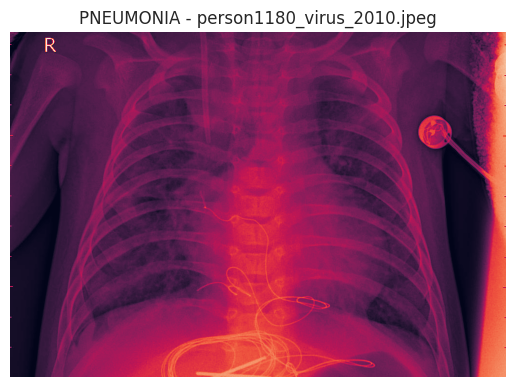

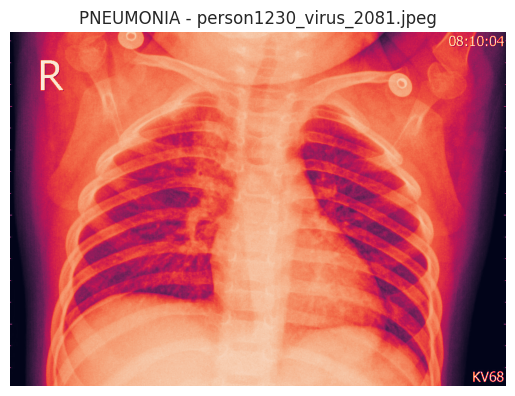

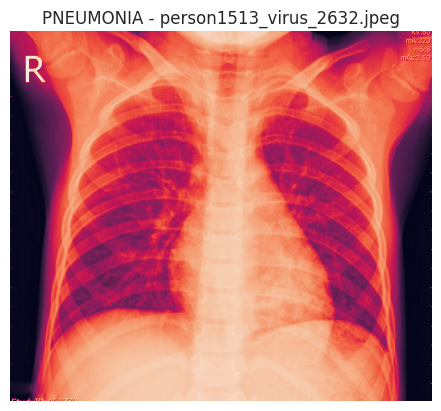

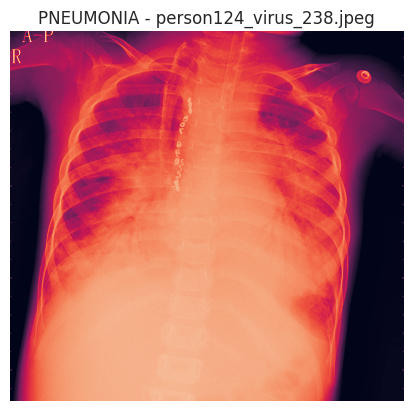

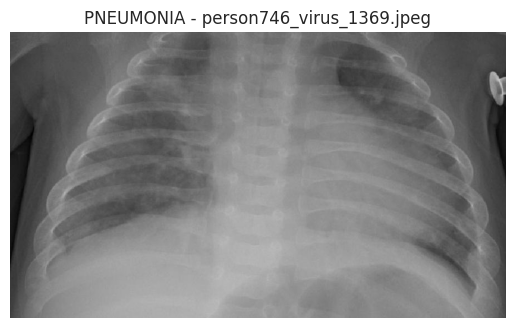

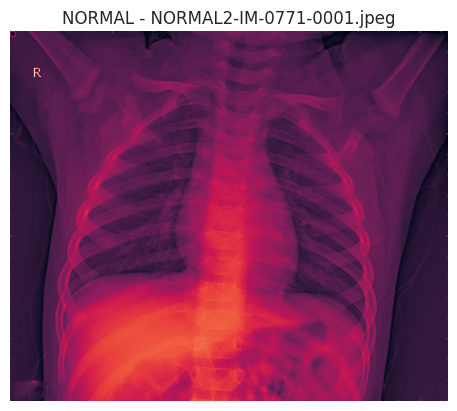

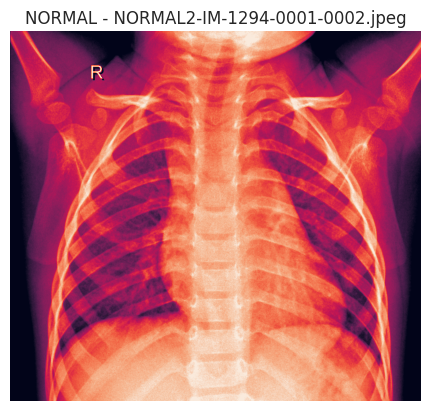

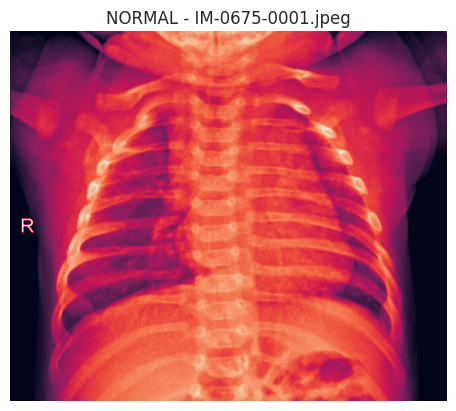

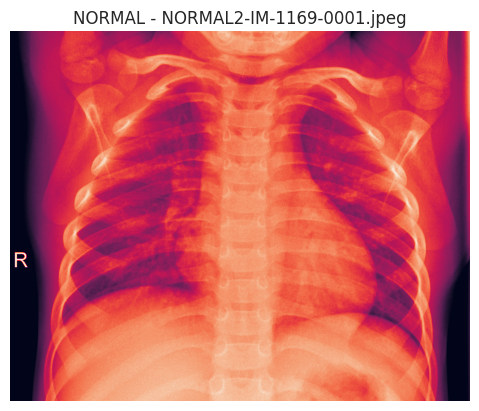

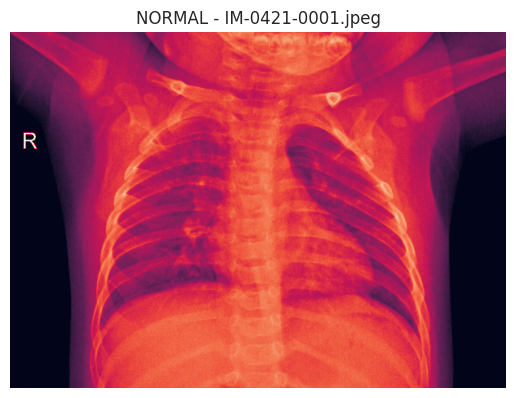

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

train_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
labels = ['PNEUMONIA', 'NORMAL']

# Görüntüleri yüklemek ve göstermek için
for label in labels:
    label_path = os.path.join(train_data, label)
    
    # Klasördeki ilk 5 görüntüyü işleme
    img_files = os.listdir(label_path)[:5]  # İlk 5 görüntü
    for img_file in img_files:
        full_path = os.path.join(label_path, img_file)
        
        # Görüntüyü aç ve göster
        img = Image.open(full_path)
        plt.imshow(img)
        plt.title(f'{label} - {img_file}')
        plt.axis('off')  # Eksenleri kapat
        plt.show()


In [14]:
import pandas as pd
import os

# Eğitim verisi dizini
train_data = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
labels = ['PNEUMONIA', 'NORMAL']

# Görüntü dosyalarının etiketlerle birlikte bir DataFrame'e aktarılması
image_paths = []
labels_list = []

for label in labels:
    label_path = os.path.join(train_data, label)
    img_files = os.listdir(label_path)
    for img_file in img_files:
        image_paths.append(os.path.join(label_path, img_file))
        labels_list.append(label)

# DataFrame oluşturma
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels_list
})


In [15]:
df.head()

image_path      label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA

In [16]:
df.tail()

image_path   label
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL

In [17]:
df.shape

(5216, 2)

In [18]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5216 non-null   object
 1   label       5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB


In [20]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [22]:
# Etiketleri sayısal değerlere çeviriyoruz
d = {'PNEUMONIA': 1, 'NORMAL': 0}
df['encode_label'] = df['label'].map(d)

In [26]:
df.head(5)

image_path      label  encode_label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA             1
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA             1
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA             1
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA             1
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA             1

In [25]:
df.tail(5)

image_path   label  encode_label
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL             0
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL             0
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL             0
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL             0
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL             0

# Veri Setinden Örnek Görseller

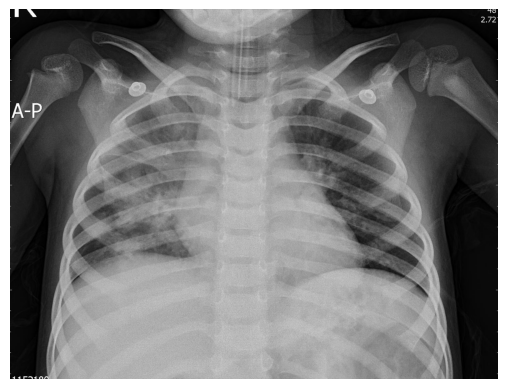

In [28]:
# 'PNEUMONIA' etiketine sahip bir görüntüyü rastgele seçip okuyoruz ve ekranda gösteriyoruz
img_path = df.loc[df['label'] == 'PNEUMONIA', 'image_path'].sample(1).values[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV renk düzenini RGB'ye dönüştürme

plt.imshow(img)
plt.axis('off')  # Eksenleri gizleme
plt.show()

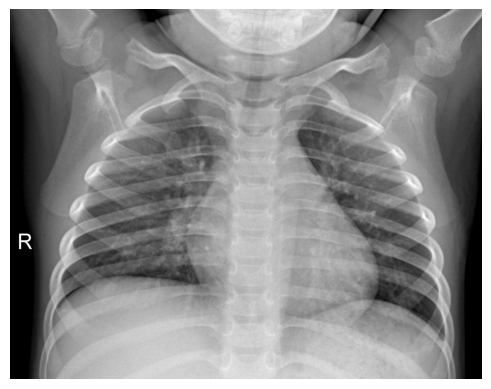

In [29]:
# 'PNEUMONIA' etiketine sahip bir görüntüyü rastgele seçip okuyoruz ve ekranda gösteriyoruz
img_path = df.loc[df['label'] == 'NORMAL', 'image_path'].sample(1).values[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV renk düzenini RGB'ye dönüştürme

plt.imshow(img)
plt.axis('off')  # Eksenleri gizleme
plt.show()

In [30]:
# DataFrame'den bir alt küme oluşturuyoruz. (örneğin, sadece 800 resim dosyasıyla çalışacağız)
df_sample = df.sample(n=2500, random_state=42)  # Sadece 800 resim dosyası seçtik.

In [31]:
df_sample.head()

image_path      label  \
1897  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA   
877   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA   
4503  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL   
4725  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL   
1595  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA   

      encode_label  
1897             1  
877              1  
4503             0  
4725             0  
1595             1

In [33]:
# Alt küme üzerinde resimleri yükleyip, boyutlandırıp ve normalize ediyoruz
x = []
for img_path in df_sample['image_path']:  # 'img' yerine 'image_path' kullanıyoruz
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (224, 224))  # Görüntüyü 224x224 boyutuna getiriyoruz
    img = img / 255.0  # Görüntüyü normalize ediyoruz
    x.append(img)

# x listesi şimdi boyutlandırılmış ve normalize edilmiş görüntüleri içeriyor


In [34]:
x = np.array(x)  # Resimleri numpy dizisine dönüştür

# Alt kümedeki etiketleri kullanarak y dizisini oluşturuyoruz.
y = df_sample['encode_label'].values  # Her bir resmin sınıfını temsil eden etiketleri (1 veya 0) içerir.

In [35]:
x.shape # Resim verisi boyutu

(2500, 224, 224, 3)

In [36]:
y.shape # Etiket verisi boyutu

(2500,)

# CNN Modeli Oluşturma ve Eğitme

In [37]:
# Eğitim ve test setlerine bölüyoruz
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Modelinizi oluşturuyorsunuz
model = Sequential()

# Convolutional ve Pooling katmanları
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten katmanı ekleyin
model.add(Flatten())

# Dense katmanları
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Overfitting'i engellemek için Dropout ekleyebilirsiniz
model.add(Dense(1, activation='sigmoid'))  # Binary sınıflandırma için

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test))


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6925 - loss: 0.6375 - val_accuracy: 0.9260 - val_loss: 0.1998
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9130 - loss: 0.2357 - val_accuracy: 0.9520 - val_loss: 0.1228
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9390 - loss: 0.1551 - val_accuracy: 0.9640 - val_loss: 0.1080
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9449 - loss: 0.1476 - val_accuracy: 0.9660 - val_loss: 0.0944
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9707 - loss: 0.0928 - val_accuracy: 0.9020 - val_loss: 0.2256
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9641 - loss: 0.0960 - val_accuracy: 0.9620 - val_loss: 0.1142
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9726 - loss: 0.0673 - val_accuracy: 0.9680 - val_loss: 0.0931
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9770 - loss: 0.0566 - val_accuracy: 0.9660 - v

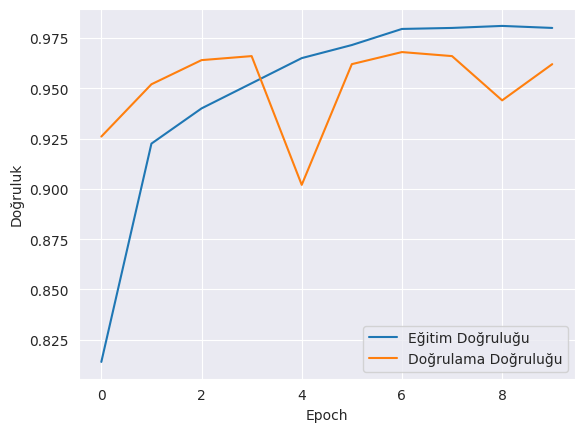

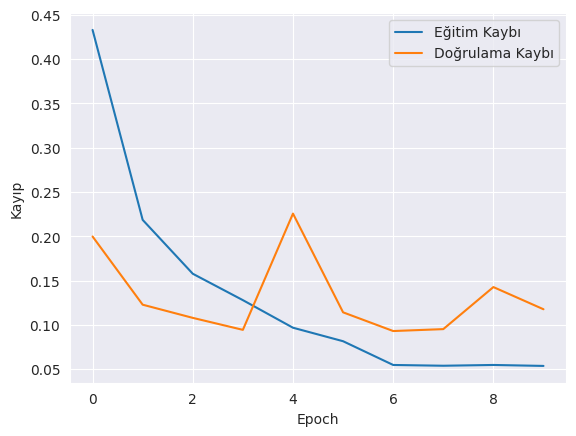

In [40]:
# Eğitim ve doğrulama performansını görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Model Performansı

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# İlk Convolutional ve Pooling katmanları
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Daha fazla Convolutional ve Pooling katmanları
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten katmanı
model.add(Flatten())

# Dense katmanları
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Overfitting'i engellemek için Dropout ekleyebilirsiniz
model.add(Dense(1, activation='sigmoid'))  # Binary sınıflandırma için

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test))


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7442 - loss: 0.5550 - val_accuracy: 0.9200 - val_loss: 0.1931
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9234 - loss: 0.2187 - val_accuracy: 0.9500 - val_loss: 0.1575
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9511 - loss: 0.1429 - val_accuracy: 0.9600 - val_loss: 0.1076
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9558 - loss: 0.1138 - val_accuracy: 0.9640 - val_loss: 0.0977
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9685 - loss: 0.0918 - val_accuracy: 0.9600 - val_loss: 0.1059
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9702 - loss: 0.0849 - val_accuracy: 0.9620 - val_loss: 0.1224
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9732 - loss: 0.0732 - val_accuracy: 0.9480 - val_loss: 0.1516
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9718 - loss: 0.0836 - val_accuracy: 0.9640 - v

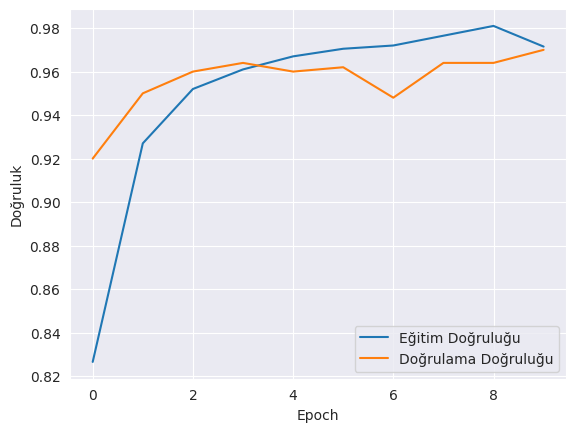

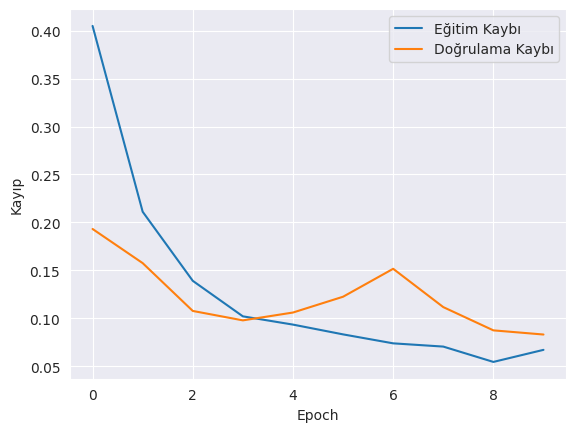

In [44]:
# Eğitim ve doğrulama performansını görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

In [45]:
model.save('model.h5')